# Stanford Dogs: Custom CNN (From Scratch)

This notebook is written as an exercise-style workflow for training and analyzing a **custom CNN** on Stanford Dogs.

## Exercise goals
By the end of this notebook, you should be able to:
- Build an end-to-end image classification pipeline using `tf.data`
- Train a residual-style CNN **without transfer learning**
- Interpret training curves (underfitting vs overfitting vs plateau)
- Evaluate with Top-1/Top-5 and confusion analysis
- Use Grad-CAM to explain model behavior on correct/incorrect predictions

## What to explain in your write-up
- Why this problem is hard (fine-grained classes with similar visual cues)
- Why each major design choice was made (augmentation, architecture depth, optimizer, LR schedule)
- What your metrics imply about model quality and limitations

## Experimental setup and rationale

This notebook is tuned for Stanford Dogs fine-grained classification:
- Slightly **larger model capacity** to reduce underfitting
- Slightly **gentler augmentation** to preserve breed-specific details
- `AdamW` + `CosineDecay` for smoother long training
- `EarlyStopping` + `ModelCheckpoint` to keep the best validation model

When presenting this in an exercise, explain each choice as a hypothesis:
- "I increased capacity because train and val were both low and close."
- "I reduced augmentation strength because over-augmentation can erase subtle texture/shape cues."
- "I used cosine LR to improve late-epoch convergence stability."

### Dataset notes
- 120 dog breeds
- TFDS standard splits: train/test = 12,000 / 8,580
- Validation is created from the training split for model selection

### Sources
- Stanford Dogs dataset page: https://vision.stanford.edu/aditya86/ImageNetDogs/main.html
- TFDS Stanford Dogs catalog: https://tensorflow.google.cn/datasets/catalog/stanford_dogs
- Cui et al. (2024), workflow elements for Stanford Dogs: https://www.mdpi.com/2306-5354/11/11/1157


In [ ]:
import os
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import layers

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Runtime tweaks for some GPU/TF builds.
tf.config.optimizer.set_experimental_options({"layout_optimizer": False})
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

I0000 00:00:1770918996.953527   42965 cpu_feature_guard.cc:227] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow: 2.22.0-dev20260211
Keras: 3.14.0.dev2026021204
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


W0000 00:00:1770919002.344977   42965 gpu_device.cc:2459] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [ ]:
# Dataset config
IMAGE_SIZE = 224   # Final model input resolution.
RESIZE_SIZE = 256  # Resize before crop to add translation/crop variation.
BATCH_SIZE = 32    
VAL_SPLIT = 0.15   # Hold-out validation from train split for model selection.
AUTOTUNE = tf.data.AUTOTUNE

TFDS_DATA_DIR = os.environ.get("TFDS_DATA_DIR", str(Path.home() / "tensorflow_datasets"))
DATASET_NAME = "stanford_dogs"
print("TFDS data dir:", TFDS_DATA_DIR)

def load_stanford_dogs_local_first(data_dir=TFDS_DATA_DIR):
    """Load Stanford Dogs from local TFDS cache first, with safe fallback prepare."""
    builder = tfds.builder(DATASET_NAME, data_dir=data_dir)
    dataset_version_dir = Path(builder.data_path)
    dataset_root = dataset_version_dir.parent

    # Clean stale partial runs that can cause FileExistsError during rename.
    if dataset_root.exists():
        for p in dataset_root.glob("incomplete.*"):
            tf.io.gfile.rmtree(str(p))

    # Fast path: use already prepared local dataset only.
    try:
        ds = tfds.load(
            DATASET_NAME,
            split=["train", "test"],
            with_info=True,
            as_supervised=True,
            data_dir=data_dir,
            download=False,
        )
        print("Using already prepared local TFDS data.")
        return ds
    except Exception as local_err:
        print(f"Local-only load failed: {type(local_err).__name__}: {local_err}")

    # Recovery path: prepare again, then load without downloading.
    print("Re-preparing dataset metadata/shards from local cache/network...")
    builder.download_and_prepare()

    return tfds.load(
        DATASET_NAME,
        split=["train", "test"],
        with_info=True,
        as_supervised=True,
        data_dir=data_dir,
        download=False,
    )

(ds_train_raw, ds_test_raw), ds_info = load_stanford_dogs_local_first()

num_classes = ds_info.features["label"].num_classes
class_names = ds_info.features["label"].names

train_count = ds_info.splits["train"].num_examples
test_count = ds_info.splits["test"].num_examples
val_count = int(train_count * VAL_SPLIT)
new_train_count = train_count - val_count

print(f"Classes: {num_classes}")
print(f"Train raw: {train_count}")
print(f"Val split from train: {val_count}")
print(f"Train used: {new_train_count}")
print(f"Test: {test_count}")


TFDS data dir: /home/vscode/tensorflow_datasets
Using already prepared local TFDS data.
Classes: 120
Train raw: 12000
Val split from train: 1800
Train used: 10200
Test: 8580


W0000 00:00:1770919007.844263   42965 gpu_device.cc:2459] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1770919008.064583   42965 gpu_device.cc:2043] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9218 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:06:00.0, compute capability: 12.0a


In [3]:
# Deterministic train/val split from the official training split
shuffled = ds_train_raw.shuffle(10000, seed=SEED, reshuffle_each_iteration=False)
ds_val_raw = shuffled.take(val_count)
ds_train_raw = shuffled.skip(val_count)

In [ ]:
# Train-time data augmentation for fine-grained classification:
# with moderate augmentations to avoid destroying subtle cues.
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.03),
    layers.RandomZoom(0.10),
    layers.RandomContrast(0.05),
], name="data_augmentation")


def train_preprocess(image, label):
    # Convert uint8 [0,255] to float32 [0,1] once.
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize then random crop is standard for classification augmentation.
    image = tf.image.resize(image, [RESIZE_SIZE, RESIZE_SIZE])
    image = tf.image.random_crop(image, [IMAGE_SIZE, IMAGE_SIZE, 3], seed=SEED)
    return image, label


def eval_preprocess(image, label):
    # Deterministic center crop for fair, stable validation/test metrics.
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [RESIZE_SIZE, RESIZE_SIZE])
    image = tf.image.central_crop(image, float(IMAGE_SIZE) / RESIZE_SIZE)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    return image, label


def prepare_train(ds):
    # Shuffle before batching; smaller buffer reduces host RAM pressure.
    ds = ds.map(train_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(2048, seed=SEED)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(1)
    return ds


def prepare_eval(ds):
    # No random ops in eval pipeline.
    ds = ds.map(eval_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(1)
    return ds


train_ds = prepare_train(ds_train_raw)
val_ds = prepare_eval(ds_val_raw)
test_ds = prepare_eval(ds_test_raw)

I0000 00:00:1770919014.768308   43193 tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


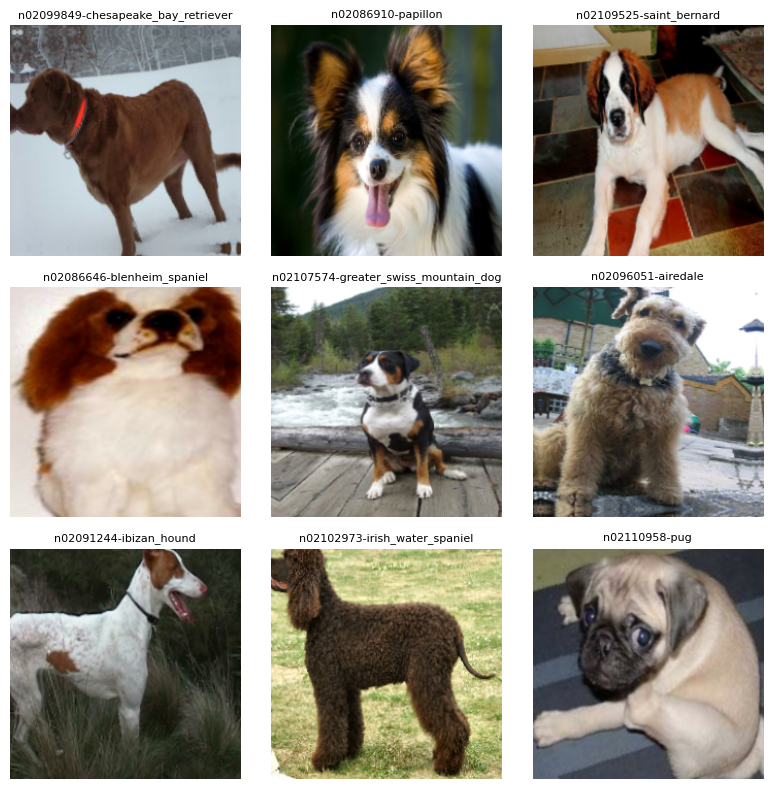

In [ ]:
# Quick visual check of images and labels after augmentation/preprocessing.
sample_images, sample_labels = next(iter(train_ds.take(1)))
aug_images = data_augmentation(sample_images[:9], training=True)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.clip(aug_images[i].numpy(), 0, 1))
    ax.set_title(class_names[int(sample_labels[i])], fontsize=8)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Custom CNN architecture

### Architecture explanation
- The network is organized into residual stages with increasing channels (`48 -> 96 -> 192 -> 320`).
- Early layers learn generic edges/textures; deeper layers learn breed-specific structure.
- Extra blocks in later stages increase representational power for fine-grained classes.
- Global average pooling keeps the classifier head compact and reduces over-parameterization risk.

### Regularization explanation
- Dropout is low in early/mid stages and moderate in the head to avoid discarding too much spatial information.
- Batch normalization stabilizes optimization and supports deeper stacks.

- Why residual connections were needed (depth + optimization stability)
- Why channel widths increase with depth
- How dropout placement affects fine-grained recognition


In [6]:
def residual_block(x, filters, stride=1, name_prefix="block"):
    """Two-conv residual block with optional projection for shape/channel match."""
    shortcut = x

    x = layers.Conv2D(filters, 3, strides=stride, padding="same", use_bias=False, name=f"{name_prefix}_conv1")(x)
    x = layers.BatchNormalization(name=f"{name_prefix}_bn1")(x)
    x = layers.Activation("relu", name=f"{name_prefix}_relu1")(x)

    x = layers.Conv2D(filters, 3, padding="same", use_bias=False, name=f"{name_prefix}_conv2")(x)
    x = layers.BatchNormalization(name=f"{name_prefix}_bn2")(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same", use_bias=False, name=f"{name_prefix}_proj")(shortcut)
        shortcut = layers.BatchNormalization(name=f"{name_prefix}_proj_bn")(shortcut)

    x = layers.Add(name=f"{name_prefix}_add")([x, shortcut])
    x = layers.Activation("relu", name=f"{name_prefix}_out")(x)
    return x


def build_custom_cnn(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), classes=num_classes):
    """Residual-style custom CNN tuned for fine-grained dog breed classification."""
    inputs = keras.Input(shape=input_shape, name="image")

    x = data_augmentation(inputs)

    x = layers.Conv2D(48, 3, strides=2, padding="same", use_bias=False, name="stem_conv")(x)
    x = layers.BatchNormalization(name="stem_bn")(x)
    x = layers.Activation("relu", name="stem_relu")(x)

    x = residual_block(x, 48, stride=1, name_prefix="stage1_block1")
    x = layers.Dropout(0.00, name="drop_stage1")(x)

    x = residual_block(x, 96, stride=2, name_prefix="stage2_block1")
    x = residual_block(x, 96, stride=1, name_prefix="stage2_block2")
    x = layers.Dropout(0.03, name="drop_stage2")(x)

    # Deeper high-channel stages increase fine-grained discrimination capacity.
    x = residual_block(x, 192, stride=2, name_prefix="stage3_block1")
    x = residual_block(x, 192, stride=1, name_prefix="stage3_block2")
    x = residual_block(x, 192, stride=1, name_prefix="stage3_block3")
    x = layers.Dropout(0.08, name="drop_stage3")(x)

    x = residual_block(x, 320, stride=2, name_prefix="stage4_block1")
    x = residual_block(x, 320, stride=1, name_prefix="stage4_block2")
    x = residual_block(x, 320, stride=1, name_prefix="stage4_block3")

    x = layers.GlobalAveragePooling2D(name="gap")(x)
    # Compact MLP head after global pooling.
    x = layers.Dense(384, activation="relu", name="head_dense")(x)
    x = layers.Dropout(0.20, name="head_dropout")(x)
    outputs = layers.Dense(classes, activation="softmax", name="predictions")(x)

    return keras.Model(inputs, outputs, name="stanford_dogs_custom_cnn")


model = build_custom_cnn()
model.summary()

Model: "stanford_dogs_custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ image[0][0]       │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ data_augmentatio… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_relu           │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_conv1 │ (None, 112, 112,  │     20,736 │ stem_relu[0][0]   │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_bn1   │ (None, 112, 112,  │        192 │ stage1_block1_co… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_relu1 │ (None, 112, 112,  │          0 │ stage1_block1_bn… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_conv2 │ (None, 112, 112,  │     20,736 │ stage1_block1_re… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_bn2   │ (None, 112, 112,  │        192 │ stage1_block1_co… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_add   │ (None, 112, 112,  │          0 │ stage1_block1_bn… │
│ (Add)               │ 48)               │            │ stem_relu[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_out   │ (None, 112, 112,  │          0 │ stage1_block1_ad… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_stage1         │ (None, 112, 112,  │          0 │ stage1_block1_ou… │
│ (Dropout)           │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block1_conv1 │ (None, 56, 56,    │     41,472 │ drop_stage1[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block1_bn1   │ (None, 56, 56,    │        384 │ stage2_block1_co… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block1_relu1 │ (None, 56, 56,    │          0 │ stage2_block1_bn… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_block1_conv2 │ (None, 56, 56,    │     82,944 │ stage2_block1_re

 Total params: 7,589,576 (28.95 MB)

 Trainable params: 7,581,160 (28.92 MB)

 Non-trainable params: 8,416 (32.88 KB)

In [7]:
# Training setup: AdamW + cosine decay + val_loss early stopping.
EPOCHS = 120
INIT_LR = 4e-4

steps_per_epoch = int(tf.data.experimental.cardinality(train_ds).numpy())
# Cosine decay across full training budget; alpha keeps a non-zero LR floor.
total_steps = EPOCHS * steps_per_epoch
lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=total_steps,
    alpha=0.05,
)
optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4)
loss = keras.losses.SparseCategoricalCrossentropy()
metrics = [
    keras.metrics.SparseCategoricalAccuracy(name="acc"),
    keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5"),
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

ckpt_path = "checkpoints/stanford_dogs_custom_cnn_best.keras"
os.makedirs("checkpoints", exist_ok=True)

callbacks = [
    # Stop if val_loss no longer improves and restore best weights.
    keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=15, restore_best_weights=True, verbose=1),
    # Persist the best checkpoint so interruptions do not lose the best epoch.
    keras.callbacks.ModelCheckpoint(filepath=ckpt_path, monitor="val_loss", mode="min", save_best_only=True, verbose=1),
    keras.callbacks.TensorBoard(log_dir="logs/stanford_dogs_custom_cnn"),
]


In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)


Epoch 1/120


I0000 00:00:1770919034.312211   43120 cuda_dnn.cc:461] Loaded cuDNN version 91002


319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - acc: 0.0171 - loss: 4.8826 - top5: 0.0591
Epoch 1: val_loss improved from None to 5.04324, saving model to checkpoints/stanford_dogs_custom_cnn_best.keras

Epoch 1: finished saving model to checkpoints/stanford_dogs_custom_cnn_best.keras
319/319 ━━━━━━━━━━━━━━━━━━━━ 83s 205ms/step - acc: 0.0180 - loss: 4.7817 - top5: 0.0701 - val_acc: 0.0061 - val_loss: 5.0432 - val_top5: 0.0344
Epoch 2/120
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - acc: 0.0223 - loss: 4.6550 - top5: 0.0915
Epoch 2: val_loss improved from 5.04324 to 4.69884, saving model to checkpoints/stanford_dogs_custom_cnn_best.keras

Epoch 2: finished saving model to checkpoints/stanford_dogs_custom_cnn_best.keras
319/319 ━━━━━━━━━━━━━━━━━━━━ 65s 196ms/step - acc: 0.0233 - loss: 4.6329 - top5: 0.0969 - val_acc: 0.0128 - val_loss: 4.6988 - val_top5: 0.0911
Epoch 3/120
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.0223 - loss: 4.5565 - top5: 0.1112
Epoch 3: val_loss improved from 

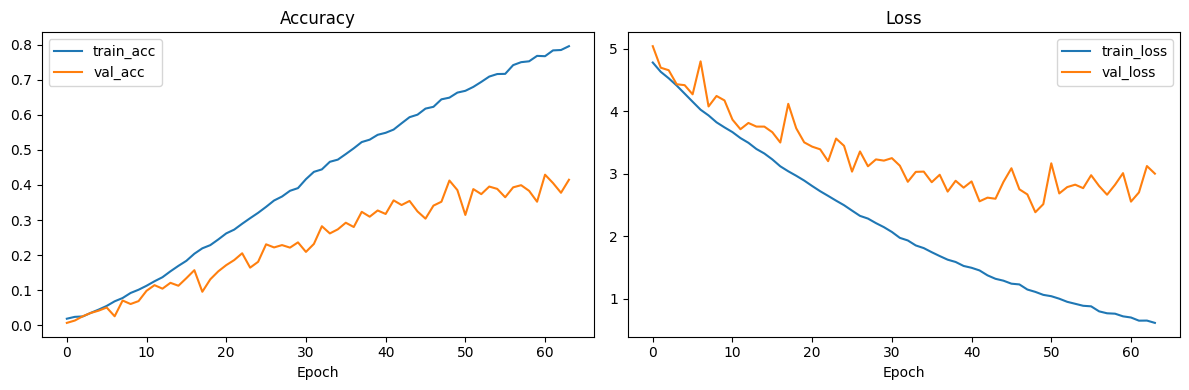

In [9]:
# Plot training curves
hist = history.history

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist["acc"], label="train_acc")
plt.plot(hist["val_acc"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Final test metrics
test_results = model.evaluate(test_ds, verbose=1)
for name, value in zip(model.metrics_names, test_results):
    print(f"{name}: {value:.4f}")

269/269 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - acc: 0.4295 - loss: 2.2790 - top5: 0.7649
loss: 2.2790
compile_metrics: 0.4295


In [11]:
# Prediction helper (streaming over tf.data dataset)
def collect_predictions(model, dataset):
    y_true, y_pred = [], []
    for images, labels in dataset:
        probs = model.predict(images, verbose=0)
        y_true.append(labels.numpy())
        y_pred.append(np.argmax(probs, axis=1))
    return np.concatenate(y_true), np.concatenate(y_pred)


y_true, y_pred = collect_predictions(model, test_ds)
print("Prediction vectors:", y_true.shape, y_pred.shape)

Prediction vectors: (8580,) (8580,)


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred, digits=3))

cm = confusion_matrix(y_true, y_pred)

# Top confused class pairs (excluding diagonal)
def top_confusions(cm, class_names, top_n=20):
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)
    flat_idx = np.argpartition(cm_no_diag.ravel(), -top_n)[-top_n:]
    flat_idx = flat_idx[np.argsort(cm_no_diag.ravel()[flat_idx])[::-1]]

    rows, cols = np.unravel_index(flat_idx, cm_no_diag.shape)
    rows_out = []
    for r, c in zip(rows, cols):
        rows_out.append((class_names[r], class_names[c], int(cm_no_diag[r, c])))
    return rows_out

for true_name, pred_name, count in top_confusions(cm, class_names, top_n=15):
    print(f"{true_name:30s} -> {pred_name:30s} : {count}")

              precision    recall  f1-score   support

           0      0.212     0.269     0.237        52
           1      0.632     0.647     0.640        85
           2      0.537     0.520     0.528       152
           3      0.274     0.347     0.306        49
           4      0.438     0.491     0.463       114
           5      0.624     0.659     0.641        88
           6      0.750     0.625     0.682        96
           7      0.429     0.375     0.400        72
           8      0.417     0.069     0.119        72
           9      0.762     0.345     0.475       139
          10      0.288     0.253     0.270        75
          11      0.492     0.305     0.377        95
          12      0.561     0.425     0.484        87
          13      0.440     0.310     0.364        71
          14      0.523     0.390     0.447        59
          15      0.465     0.377     0.417        53
          16      0.494     0.684     0.574        57
          17      0.259    

## Optional Grad-CAM (correct + incorrect predictions)

Use this section to produce qualitative evidence for your exercise discussion.

What to check when you interpret heatmaps:
- Correct prediction: does attention focus on the dog body/head rather than background?
- Wrong prediction: is attention on irrelevant context (grass, leash, human, cage)?
- Confusable breeds: does the model focus on weak cues while missing discriminative ones?

Helper functions are loaded from: `exercise_11/gradcam.py`.

In [13]:
import sys
sys.path.append(str(Path("..").resolve()))

from exercise_11.gradcam import make_gradcam_heatmap, create_gradcam_visualization

In [14]:
# Build a small pool of test images for CAM examples
unbatched_test = ds_test_raw.map(eval_preprocess, num_parallel_calls=AUTOTUNE)

examples = []
for image, label in unbatched_test.take(128):
    pred = np.argmax(model.predict(tf.expand_dims(image, axis=0), verbose=0), axis=1)[0]
    examples.append((image.numpy(), int(label.numpy()), int(pred)))

correct_examples = [e for e in examples if e[1] == e[2]][:2]
wrong_examples = [e for e in examples if e[1] != e[2]][:2]
selected = correct_examples + wrong_examples

print(f"Selected {len(correct_examples)} correct and {len(wrong_examples)} incorrect examples")

Selected 2 correct and 2 incorrect examples


/home/vscode/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['image']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


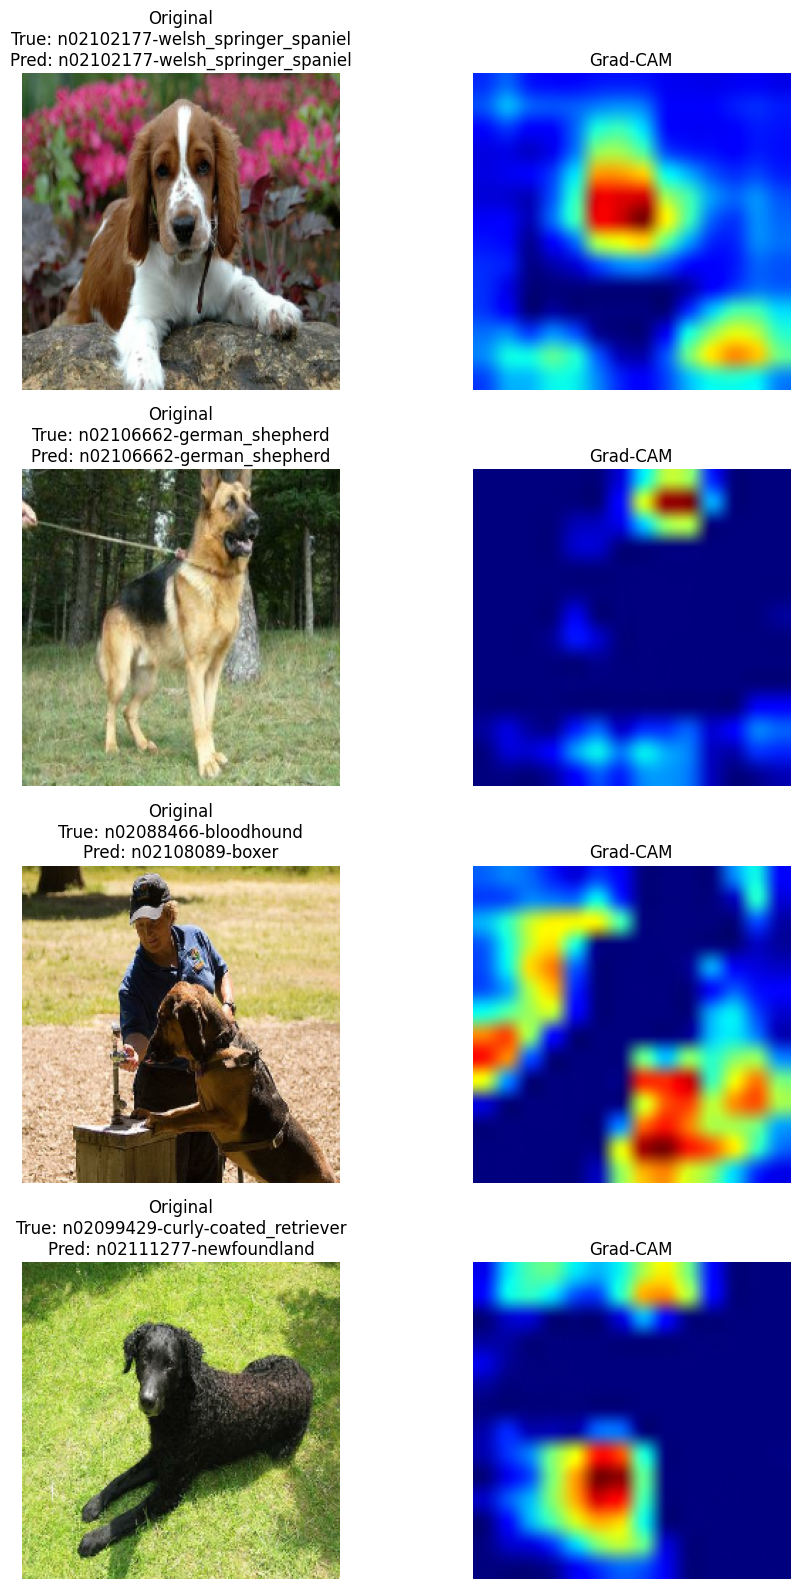

In [15]:
last_conv_layer_name = "stage4_block2_conv2"

fig, axes = plt.subplots(len(selected), 2, figsize=(10, 4 * max(1, len(selected))))
if len(selected) == 1:
    axes = np.array([axes])

for i, (img, y_t, y_p) in enumerate(selected):
    img_batch = np.expand_dims(img, axis=0)
    heatmap = make_gradcam_heatmap(
        img_array=img_batch,
        model=model,
        base_model=None,
        last_conv_layer_name=last_conv_layer_name,
        pred_index=y_p,
    )
    cam_img = create_gradcam_visualization(img, heatmap, alpha=0.5, background_intensity=0.7)

    axes[i, 0].imshow(np.clip(img, 0, 1))
    axes[i, 0].set_title(f"Original\nTrue: {class_names[y_t]}\nPred: {class_names[y_p]}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(cam_img)
    axes[i, 1].set_title("Grad-CAM")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

## Report-ready summary 

### Core results
- Best validation accuracy: `...`
- Best validation loss: `...`
- Test Top-1 accuracy: `...`
- Test Top-5 accuracy: `...`

### Curve interpretation
- Evidence of underfitting / overfitting / stable convergence: `...`
- Epoch where performance plateaued: `...`
- Final train-vs-val gap and interpretation: `...`

### Error analysis
- Most confused breed pairs: `...`
- Likely visual reason for confusion: `...`
- Observed Grad-CAM failure mode: `...`

### Final model configuration (for comparison table)
- Model: `Custom CNN (from scratch, residual)`
- Input: `224x224` (resize 256 + crop)
- Optimizer: `AdamW(weight_decay=1e-4)`
- LR schedule: `CosineDecay` (to 5% floor)
- Epoch budget: `120` (with early stopping)
- Metrics: `Top-1`, `Top-5`, confusion analysis, Grad-CAM
